In [3]:
import json
import math
import pandas as pd

In [ ]:


# Load the diseases list from a CSV file
diseases_df = pd.read_csv("disease_list.csv")
diseases_df = diseases_df.replace(r"^ +| +$", r"", regex=True)
disease_keywords = diseases_df['Disease'].str.lower().tolist()  # Convert to lowercase for case-insensitive matching
disease_keyword_dict = set(disease_keywords)

def extract_diseases_from_text(text, disease_keywords):
    """
    Extracts diseases directly from text by matching against a predefined list of diseases.
    """
    matched_diseases = []
    text = text.lower()

    # Check if any disease keyword exists as a substring in the text
    for disease in disease_keyword_dict:
        if disease in text:
            matched_diseases.append(disease)
    return list(set(matched_diseases))  # Remove duplicates

def process_batch(batch_data, disease_keywords):
    """
    Processes a batch of data and extracts disease information.
    """
    results = []
    for patient in batch_data:
        patient_text = patient.get("patient", "")
        title_text = patient.get("title", "")

        # Extract diseases from patient text and title
        diseases_from_patient = extract_diseases_from_text(patient_text, disease_keyword_dict)
        diseases_from_title = extract_diseases_from_text(title_text, disease_keyword_dict)
        diseases_from_both = list(set(diseases_from_patient) & set(diseases_from_title))
        
        # Determine the final 'disease' field
        if diseases_from_both:
            disease = diseases_from_both
        elif diseases_from_title:
            disease = diseases_from_title
        else:
            disease = diseases_from_patient

        # Extract age and age units from the `age` field
        age_data = patient.get("age", [[None, None]])[0]
        extracted_age = int(math.floor(age_data[0])) if isinstance(age_data[0], (int, float)) else None
        extracted_age_units = age_data[1] if isinstance(age_data[1], str) else None

        # Append the patient data along with the extracted diseases and age fields
        results.append({
            "patient_id": patient.get("patient_id"),
            "patient_uid": patient.get("patient_uid"),
            "patient": patient_text,
            "title": title_text,
            "age": extracted_age,
            "age_units": extracted_age_units,
            "gender": patient.get("gender"),
            "similar_patients": patient.get("similar_patients"),
            "diseases_from_patient": ", ".join(diseases_from_patient),
            "diseases_from_title": ", ".join(diseases_from_title),
            "diseases_from_both": ", ".join(diseases_from_both),
            "disease": ", ".join(disease)  # Final disease field
        })
    return results

# Read input JSON data
input_file = "null_disease_records.json"
output_file = "null_disease.csv"
chunk_size = 1000

with open(input_file, "r") as file:
    data = json.load(file)

# Initialize an empty DataFrame to store all results
final_results_df = pd.DataFrame()

# Process data in batches and append to the DataFrame
for i in range(0, len(data), chunk_size):
    batch_data = data[i:i + chunk_size]
    processed_results = process_batch(batch_data, disease_keywords)
    
    # Convert the batch results to a DataFrame and append to final_results_df
    batch_df = pd.DataFrame(processed_results)
    final_results_df = pd.concat([final_results_df, batch_df], ignore_index=True)
    
    print(f"Processed and appended batch {i // chunk_size + 1}")

# Save the final results to CSV
final_results_df.to_csv(output_file, index=False)
print(f"Final data saved to '{output_file}'")


In [5]:
df = pd.read_csv("updated_full_patients.csv")

# Display the DataFrame (optional)
df.head()

,patient_id,patient_uid,patient,title,age,age_units,gender,similar_patients,diseases_from_patient,diseases_from_title,diseases_from_both,disease
0,0,7665777-1,This 60-year-old male was hospitalized due to ...,Early Physical Therapist Interventions for Pat...,60,year,M,"{'7665777-2': 2, '7665777-3': 2, '7665777-4': ...","respiratory failure, covid-19",covid-19,covid-19,covid-19
1,1,7665777-2,A 39-year-old man was hospitalized due to an i...,Early Physical Therapist Interventions for Pat...,39,year,M,"{'7665777-1': 2, '7665777-3': 2, '7665777-4': ...",anxiety,covid-19,NaN,covid-19
2,2,7665777-3,One week after a positive COVID-19 result this...,Early Physical Therapist Interventions for Pat...,57,year,M,"{'7665777-1': 2, '7665777-2': 2, '7665777-4': ...",covid-19,covid-19,covid-19,covid-19
3,3,7665777-4,This 69-year-old male was admitted to the ICU ...,Early Physical Therapist Interventions for Pat...,69,year,M,"{'7665777-1': 2, '7665777-2': 2, '7665777-3': ...","pneumonia, covid-19",covid-19,covid-19,covid-19
4,4,7665777-5,This 57-year-old male was admitted to the ICU ...,Early Physical Therapist Interventions for Pat...,57,year,M,"{'7665777-1': 2, '7665777-2': 2, '7665777-3': ...","respiratory failure, covid-19",covid-19,covid-19,covid-19


In [6]:
print(df[['diseases_from_patient', 'diseases_from_title', 'diseases_from_both', 'disease']].isnull().mean())


diseases_from_patient    0.236263
diseases_from_title      0.489403
diseases_from_both       0.686273
disease                  0.001132
dtype: float64


In [7]:
df_temp = df[df['disease'].isna()]
len(df_temp)

189

In [10]:
df_temp_1 = df[df['diseases_from_patient'].isna()]
len(df_temp_1)

39464

In [11]:
df_temp_1 = df[df['diseases_from_title'].isna()]
len(df_temp_1)

81747

In [12]:
df_temp_1 = df[df['diseases_from_both'].isna()]
len(df_temp_1)

114631

In [18]:
def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 0

df['similarity_ratio'] = df.apply(
    lambda row: jaccard_similarity(
        set(str(row['diseases_from_patient']).split(', ') if pd.notna(row['diseases_from_patient']) else []),
        set(str(row['diseases_from_title']).split(', ') if pd.notna(row['diseases_from_title']) else [])
    ), axis=1
)
print(df['similarity_ratio'].describe())



count    167034.000000
mean          0.149365
std           0.276037
min           0.000000
25%           0.000000
50%           0.000000
75%           0.200000
max           1.000000
Name: similarity_ratio, dtype: float64


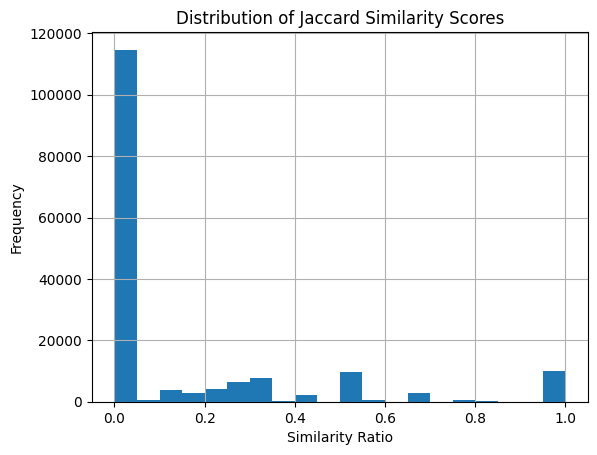

In [19]:
import matplotlib.pyplot as plt
df['similarity_ratio'].hist(bins=20)
plt.title("Distribution of Jaccard Similarity Scores")
plt.xlabel("Similarity Ratio")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import pandas as pd
null_df = pd.read_csv('null_disease.csv')
# null_df = null_df[null_df['disease'].isna()]
# null_df.to_csv('null_disease.csv', index=False)
len(null_df)

In [ ]:
null_df['title'] = null_df['title'].str.strip()
unique_titles = null_df['title'].unique()


# Extract unique titles
unique_titles = null_df['title'].unique()

# Convert the array of unique titles to a DataFrame
unique_titles_df = pd.DataFrame(unique_titles, columns=['title'])

# Save the DataFrame to a CSV file
unique_titles_df.to_csv('unique_titles.csv', index=False)

print("Unique titles have been saved to 'unique_titles.csv'")



In [ ]:
import json

# Define UK to US spelling conversions
uk_to_us_spelling = {
    "leukaemia": "leukemia",
    "Leukaemia": "Leukemia",
    # Add more UK-to-US conversions as needed
}

def replace_uk_spelling(text):
    """Replace UK spellings with US spellings in the text."""
    for uk, us in uk_to_us_spelling.items():
        text = text.replace(uk, us)
    return text

# Open and load the JSON file
input_file = "filtered_null_disease_records.json"
output_file = "null_disease_records.json"

with open(input_file, "r") as file:
    data = json.load(file)

# Recursively update text fields in the JSON data
def update_spelling(obj):
    if isinstance(obj, dict):
        return {key: update_spelling(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [update_spelling(item) for item in obj]
    elif isinstance(obj, str):
        return replace_uk_spelling(obj)
    else:
        return obj

# Apply the spelling update to the JSON data
updated_data = update_spelling(data)

# Save the updated JSON to a new file
with open(output_file, "w") as file:
    json.dump(updated_data, file, indent=4)

print(f"Updated JSON saved to '{output_file}'")


In [1]:
import spacy
import pandas as pd

# Load the SciSpaCy model for disease extraction
nlp = spacy.load("en_ner_bc5cdr_md")

# Load the CSV file
df = pd.read_csv("null_disease.csv")

# Function to extract conditions using SciSpaCy
def extract_conditions(text):
    conditions = []
    if pd.notna(text):  # Check if text is not NaN
        doc = nlp(text)
        for ent in doc.ents:
            if ent.label_ == "DISEASE":
                conditions.append(ent.text)
    return conditions

# Process in batches of 1000 records
batch_size = 1000
output_file = "updated_null_disease.csv"

# Initialize an empty list to store processed data
processed_data = []

# Iterate over data in batches
for start in range(0, len(df), batch_size):
    batch = df[start:start + batch_size].copy()

    # Apply extraction to both the 'patient' and 'title' columns
    batch['diseases_from_patient'] = batch['patient'].apply(lambda x: extract_conditions(x))
    batch['diseases_from_title'] = batch['title'].apply(lambda x: extract_conditions(x))
    batch['diseases_from_both'] = batch.apply(
        lambda row: list(set(row['diseases_from_patient']) & set(row['diseases_from_title'])), axis=1
    )

    # Append processed batch to the list
    processed_data.append(batch)

    print(f"Processed batch {start // batch_size + 1}")

# Concatenate all processed batches
final_df = pd.concat(processed_data, ignore_index=True)

# Save the updated DataFrame to a new CSV file
final_df.to_csv(output_file, index=False)

print(f"Updated CSV file saved to '{output_file}'")


/Users/manasa/anaconda3/envs/anything/lib/python3.12/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


Processed batch 1
Processed batch 2
Processed batch 3
Processed batch 4
Processed batch 5
Processed batch 6
Processed batch 7
Processed batch 8
Processed batch 9
Processed batch 10
Processed batch 11
Processed batch 12
Processed batch 13
Processed batch 14
Processed batch 15
Processed batch 16
Processed batch 17
Processed batch 18
Processed batch 19
Processed batch 20
Processed batch 21
Processed batch 22
Processed batch 23
Processed batch 24
Processed batch 25
Processed batch 26
Processed batch 27
Processed batch 28
Processed batch 29
Updated CSV file saved to 'updated_null_disease.csv'


In [13]:
df_1 = pd.read_csv("final_updated_null_disease.csv")
len(df_1)
df_1 = df_1[df_1['disease'].isna()]
len(df_1)


0

In [9]:
nlp = spacy.load("en_ner_bc5cdr_md")


In [ ]:

df_2 = pd.read_csv("updated_null_disease.csv")

# Determine the final 'disease' field for each record
def get_final_disease(row):
    if row['diseases_from_both']:
        return row['diseases_from_both']
    elif row['diseases_from_title']:
        return row['diseases_from_title']
    else:
        return row['diseases_from_patient']

# Apply the function to each row
df_2['disease'] = df_2.apply(get_final_disease, axis=1)

# Save the updated DataFrame to a CSV file
df_2.to_csv("final_updated_null_disease.csv", index=False)

print("Updated CSV file saved to 'final_updated_null_disease.csv'")


Updated CSV file saved to 'final_updated_null_disease.csv'


In [15]:

full_patients = pd.read_csv("full_patients.csv")
updated_null_disease = pd.read_csv("final_updated_null_disease.csv")

# Merge the DataFrames on the 'patient_id' column
merged_df = full_patients.merge(updated_null_disease[['patient_id', 'disease']], 
                                on='patient_id', how='left', suffixes=('', '_updated'))

# Update the 'disease' column in full_patients if it's empty
merged_df['disease'] = merged_df.apply(
    lambda row: row['disease_updated'] if pd.isna(row['disease']) or row['disease'] == '' else row['disease'], axis=1
)

# Drop the temporary 'disease_updated' column
merged_df.drop(columns=['disease_updated'], inplace=True)

# Save the updated DataFrame to a new CSV file
merged_df.to_csv("updated_full_patients.csv", index=False)

print("Updated CSV file saved to 'updated_full_patients.csv'")


Updated CSV file saved to 'updated_full_patients.csv'
